In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gmean, gstd
from matplotlib import pyplot as plt

import geopandas as gpd
import plotly.express as px
from plotly import graph_objects as go

import viz
colors = viz.plotting_style()

In [56]:
# units are gC/m2/yr
srdb = pd.read_csv('../data/SRDB_V5_1827/data/srdb-data-V5.csv')
srdb_studies = pd.read_csv('../data/SRDB_V5_1827/data/srdb-studies-V5.csv', encoding = "ISO-8859-1")
srdb_equations = pd.read_csv('../data/SRDB_V5_1827/data/srdb-equations-V5.csv', encoding = "ISO-8859-1")

# Entry_date is a date-time in the format 'YYYY-MM-DD'
srdb['Entry_datetime'] = pd.to_datetime(srdb['Entry_date'], format='%Y-%m-%d')

# Fetch the year of publication via "Study_number"
srdb['measured_year'] = srdb_studies.set_index('Study_number').loc[srdb['Study_number'], 'PubYear'].values

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_60702/2140980518.py:2: DtypeWarning: Columns (4,39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  srdb = pd.read_csv('../data/SRDB_V5_1827/data/srdb-data-V5.csv')


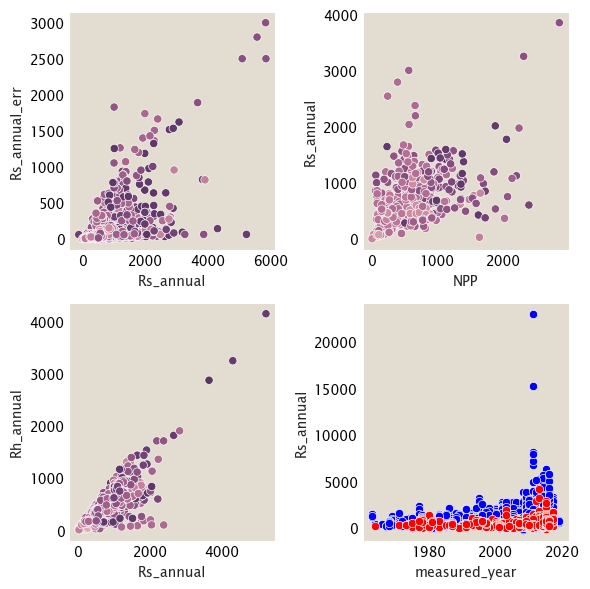

In [22]:
mosaic = "AB\nCD"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(6, 6))

plt.sca(axs['A'])
sns.scatterplot(data=srdb, x='Rs_annual', y='Rs_annual_err', hue='MAT', legend=False)

plt.sca(axs['B'])
sns.scatterplot(data=srdb, x='NPP', y='Rs_annual', hue='MAT', legend=False)

plt.sca(axs['C'])
sns.scatterplot(data=srdb, x='Rs_annual', y='Rh_annual', hue='MAT', legend=False)

plt.sca(axs['D'])
sns.scatterplot(data=srdb, x='measured_year', y='Rs_annual', color='b', legend=False)
sns.scatterplot(data=srdb, x='measured_year', y='Rh_annual', color='r', legend=False)


plt.tight_layout()
plt.show()

In [62]:
srdb_equations.columns

Index(['Record_number', 'Model_type', 'Temp_effect', 'Model_output_units',
       'Model_temp_min', 'Model_temp_max', 'Model_N', 'Model_R2', 'T_depth',
       'Model_paramA', 'Model_paramB', 'Model_paramC', 'Model_paramD',
       'Model_paramE', 'WC_effect', 'R10', 'Q10_0_10', 'Q10_5_15', 'Q10_10_20',
       'Q10_0_20', 'Q10_other1', 'Q10_other1_temp_min', 'Q10_other1_temp_max',
       'Q10_other2', 'Q10_other2_temp_min', 'Q10_other2_temp_max'],
      dtype='object')

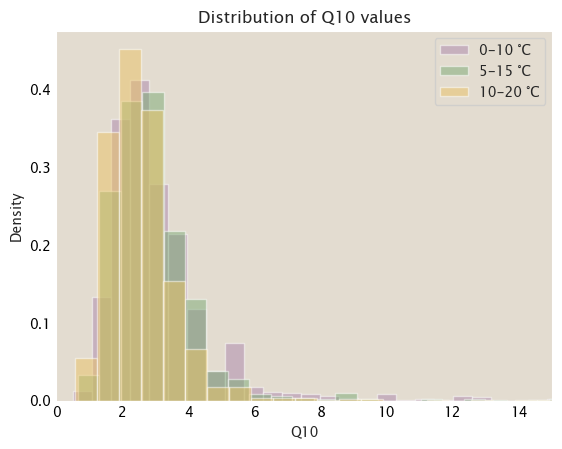

In [ ]:
# plot the distribution of Q10 values
plt.figure()

plt.hist(srdb_equations.Q10_0_10, bins=50, color=colors['purple'], density=True,
         label='0-10 °C', alpha=0.5)
plt.hist(srdb_equations.Q10_5_15, bins=50, color=colors['green'], density=True,
         label='5-15 °C', alpha=0.5)
plt.hist(srdb_equations.Q10_10_20, bins=50, color=colors['yellow'], density=True,
         label='10-20 °C', alpha=0.5)

plt.xlabel('Q10')
plt.ylabel('Density')
plt.title('measured Q10 values')
plt.legend(loc='upper right')
plt.xlim(0, 15)
plt.show()

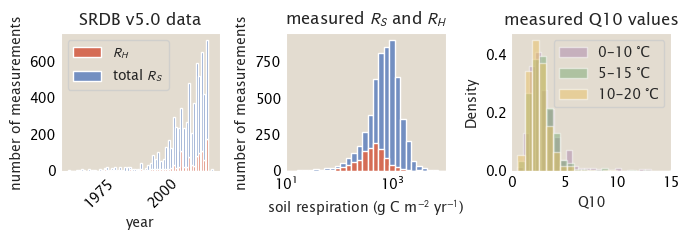

In [78]:
mosaic = "ABC"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7, 2.5))

plt.sca(axs['A'])

# plot the number of Rh measurements per year
mask = srdb.Rh_annual.notnull()
Rh_counts = srdb[mask].groupby('measured_year').size()

# plot the number of Rs measurements per year
mask = srdb.Rs_annual.notnull()
Rs_counts = srdb[mask].groupby('measured_year').size()

min_yr = min(Rh_counts.index.min(), Rs_counts.index.min())
max_yr = max(Rh_counts.index.max(), Rs_counts.index.max())
years = np.arange(min_yr, max_yr+1)
Rh_counts = Rh_counts.reindex(years, fill_value=0)
Rs_counts = Rs_counts.reindex(years, fill_value=0)

plt.bar(years, Rh_counts, color=colors['red'], label='$R_H$')
plt.bar(years, Rs_counts, bottom=Rh_counts, color=colors['blue'], label='total $R_S$')

plt.legend(loc='upper left')

plt.xlabel('year')
plt.ylabel('number of measurements')
plt.title('SRDB v5.0 data')
plt.xticks(rotation=45)

plt.sca(axs['B'])
plt.xscale('log')
bins = np.logspace(1,6,50)
plt.hist(srdb.Rs_annual, bins=bins, edgecolor='w', lw=1, color=colors['blue'])
plt.hist(srdb.Rh_annual, bins=bins, edgecolor='w', lw=1, color=colors['red'])

plt.xlabel('soil respiration (g C m$^{-2}$ yr$^{-1}$)')
plt.ylabel('number of measurements')
plt.xlim(10, 1e4)
plt.title(f'measured $R_S$ and $R_H$')

plt.sca(axs['C'])
plt.hist(srdb_equations.Q10_0_10, bins=50, color=colors['purple'], density=True,
         label='0-10 °C', alpha=0.5)
plt.hist(srdb_equations.Q10_5_15, bins=50, color=colors['green'], density=True,
         label='5-15 °C', alpha=0.5)
plt.hist(srdb_equations.Q10_10_20, bins=50, color=colors['yellow'], density=True,
         label='10-20 °C', alpha=0.5)

plt.xlabel('Q10')
plt.ylabel('Density')
plt.title('measured Q10 values')
plt.legend(loc='upper right')
plt.xlim(0, 15)

plt.tight_layout()
plt.show()

In [51]:
# Fit rs and rh to a lognormal distribution using scipy
from scipy.stats import lognorm
from scipy.stats import kstest

def fit_lognormal(data):
    # Fit a lognormal distribution to the data
    shape, loc, scale = lognorm.fit(data, floc=0)
    # Calculate the mean and standard deviation of the fitted distribution
    mean = np.exp(np.log(scale) + 0.5 * shape**2)
    std = np.sqrt((np.exp(shape**2) - 1) * np.exp(2 * np.log(scale) + shape**2))
    median = np.exp(np.log(scale))
    return shape, loc, scale, median, mean, std


# Fit the lognormal distribution to Rs_annual and Rh_annual
mask_Rs = np.logical_and(srdb.Rs_annual.notnull(), srdb.Rs_annual > 0)
mask_Rh = np.logical_and(srdb.Rs_annual.notnull(), srdb.Rh_annual > 0)
Rs_shape, Rs_loc, Rs_scale, Rs_mean, Rs_median, Rs_std = fit_lognormal(srdb[mask_Rs].Rs_annual)
Rh_shape, Rh_loc, Rh_scale, Rh_mean, Rh_median, Rh_std = fit_lognormal(srdb[mask_Rh].Rh_annual)
print(f"Rs_annual: shape={Rs_shape}, loc={Rs_loc}, scale={Rs_scale}, median={Rs_median}, mean={Rs_mean}, std={Rs_std}")
print(f"Rh_annual: shape={Rh_shape}, loc={Rh_loc}, scale={Rh_scale}, median={Rh_median}, mean={Rh_mean}, std={Rh_std}")
# Perform the Kolmogorov-Smirnov test
Rs_statistic, Rs_p_value = kstest(srdb.Rs_annual.dropna(), 'lognorm', args=(Rs_shape, Rs_loc, Rs_scale))
Rh_statistic, Rh_p_value = kstest(srdb.Rh_annual.dropna(), 'lognorm', args=(Rh_shape, Rh_loc, Rh_scale))
print(f"Rs_annual: KS statistic={Rs_statistic}, p-value={Rs_p_value}")
print(f"Rh_annual: KS statistic={Rh_statistic}, p-value={Rh_p_value}")

# Calculate the raw medians and means for both
Rs_annual = srdb[mask_Rs].Rs_annual
Rh_annual = srdb[mask_Rh].Rh_annual
Rs_median_raw = np.median(Rs_annual)
Rh_median_raw = np.median(Rh_annual)
Rs_mean_raw = np.mean(Rs_annual)
Rh_mean_raw = np.mean(Rh_annual)
print(f"Rs_annual: raw median={Rs_median_raw}, raw mean={Rs_mean_raw}")
print(f"Rh_annual: raw median={Rh_median_raw}, raw mean={Rh_mean_raw}")



Rs_annual: shape=0.7485556908065243, loc=0, scale=675.1524306465097, median=893.464229513466, mean=675.1524306465097, std=774.4124923472046
Rh_annual: shape=0.6826748920191539, loc=0, scale=388.7300620598252, median=490.7366742633611, mean=388.7300620598252, std=378.11530682777294
Rs_annual: KS statistic=0.0721302221894029, p-value=2.028019905200937e-26
Rh_annual: KS statistic=0.06925611439942442, p-value=7.994476254878812e-05
Rs_annual: raw median=732.0, raw mean=854.9038691290991
Rh_annual: raw median=420.0, raw mean=479.31325495190845


In [77]:
# Calculate the raw mean and medians of the Q10 values
Q10_0_10 = srdb_equations.Q10_0_10
Q10_5_15 = srdb_equations.Q10_5_15
Q10_10_20 = srdb_equations.Q10_10_20
Q10_0_10_median = np.nanmedian(Q10_0_10)
Q10_5_15_median = np.nanmedian(Q10_5_15)
Q10_10_20_median = np.nanmedian(Q10_10_20)
Q10_0_10_mean = np.mean(Q10_0_10)
Q10_5_15_mean = np.mean(Q10_5_15)
Q10_10_20_mean = np.mean(Q10_10_20)

print(f"Q10_0_10: raw median={Q10_0_10_median}, raw mean={Q10_0_10_mean}")
print(f"Q10_5_15: raw median={Q10_5_15_median}, raw mean={Q10_5_15_mean}")
print(f"Q10_10_20: raw median={Q10_10_20_median}, raw mean={Q10_10_20_mean}")

Q10_0_10: raw median=2.72, raw mean=3.270743187645208
Q10_5_15: raw median=2.7, raw mean=2.981456135863317
Q10_10_20: raw median=2.404838923, raw mean=2.6289841030129266


In [22]:
mask = srdb.Rh_annual > 0
rh_gmean = gmean(srdb[mask].Rh_annual)
rh_gstd = gstd(srdb[mask].Rh_annual)
print(f"Geometric mean Rh: {rh_gmean:.2f} g C/m2/yr")
print(f"Geometric std Rh: {rh_gstd:.2f} fold")

rh_mean = srdb[mask].Rh_annual.mean()
rh_std = srdb[mask].Rh_annual.std()
print(f"Mean Rh: {rh_mean:.2f} g C/m2/yr")
print(f"Std Rh: {rh_std:.2f} g C/m2/yr")

Geometric mean Rh: 390.27 g C/m2/yr
Geometric std Rh: 2.02 fold
Mean Rh: 480.41 g C/m2/yr
Std Rh: 340.86 g C/m2/yr


In [3]:
microbes_g_range = (1e7, 1e9) # cells/g
g_per_m3 = 1e6 # g/m3
# Sample from log-uniform distribution
microbes_per_g = np.random.uniform(*microbes_g_range, size=10000)
microbes_per_m3 = pd.Series(microbes_per_g * g_per_m3)
metabolic_rate = 3e-15 # mol CO2/cell/hr -- based on kayser et al and fx100 fg/cell
# 1 mol CO2 has 1 mol C, each m3 has a surface area of 1 m2
rates_molC_hr = microbes_per_m3 * metabolic_rate 
rates_gC_yr = 24*365 * rates_molC_hr * 12

gmean_rate_gC_yr = gmean(rates_gC_yr)
min_rate_gC_yr = rates_gC_yr.min()
max_rate_gC_yr = rates_gC_yr.max()
gstd_rate_gC_yr = gstd(rates_gC_yr)
print(f'Geometric mean: {gmean_rate_gC_yr:.2e} g C/yr')
print(f'Geometric std: {gstd_rate_gC_yr:.2e} g C/yr')

pd.Series(rates_gC_yr).describe()


Geometric mean: 1.23e+05 g C/yr
Geometric std: 2.41e+00 g C/yr


count     10000.000000
mean     160241.585339
std       90016.093945
min        3194.652282
25%       82988.709954
50%      161334.162181
75%      238375.776297
max      315330.459385
dtype: float64

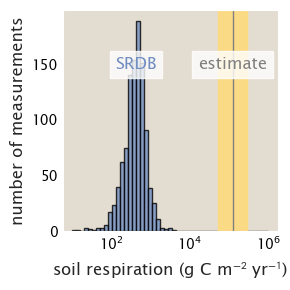

In [4]:
fig, axs = plt.subplots(figsize=(3,3))

bins = np.logspace(1,6,50)
plt.xscale('log')
plt.hist(srdb.Rh_annual, alpha=.8, bins=bins, edgecolor='k', lw=1, color='#738FC2')
med = srdb.Rh_annual.median()
#plt.title('global soil respiration DB
plt.xlabel('soil respiration (g C m$^{-2}$ yr$^{-1}$)', fontsize=12)
plt.ylabel('number of measurements', fontsize=12)

pal = sns.color_palette('YlOrBr')
plt.axvspan(gmean_rate_gC_yr/gstd_rate_gC_yr, gmean_rate_gC_yr*gstd_rate_gC_yr,
            color=pal[1], alpha=0.9)
plt.axvline(gmean_rate_gC_yr, color='grey', ls='-', lw=1)
plt.tick_params(which='both', color='w', direction='in')

# Label the data and estimates on the plot 
plt.text(med, 150, 'SRDB', fontsize=12, color='#738FC2', fontweight='bold',
         ha='center', va='center', bbox=dict(facecolor='w', edgecolor='w', alpha=0.8))
plt.text(gmean_rate_gC_yr, 150, 'estimate', fontsize=12, color='grey', fontweight='bold',
        ha='center', va='center', bbox=dict(facecolor='w', edgecolor='w', alpha=0.8))

plt.tight_layout()
plt.savefig('../output/soil_resp_db.png', facecolor='w', dpi=300)
plt.show()

In [5]:
srdb.columns

Index(['Record_number', 'Entry_date', 'Study_number', 'Author',
       'Duplicate_record', 'Quality_flag', 'Contributor', 'Country', 'Region',
       'Site_name', 'Site_ID', 'Study_midyear', 'YearsOfData', 'Latitude',
       'Longitude', 'Elevation', 'Manipulation', 'Manipulation_level',
       'Age_ecosystem', 'Age_disturbance', 'Species', 'Biome',
       'Ecosystem_type', 'Ecosystem_state', 'Leaf_habit', 'Stage', 'Soil_type',
       'Soil_drainage', 'Soil_BD', 'Soil_CN', 'Soil_sand', 'Soil_silt',
       'Soil_clay', 'MAT', 'MAP', 'PET', 'Study_temp', 'Study_precip',
       'Meas_method', 'Collar_height', 'Collar_depth', 'Chamber_area',
       'Time_of_day', 'Meas_interval', 'Annual_coverage', 'Partition_method',
       'Rs_annual', 'Rs_annual_err', 'Rs_interann_err', 'Rlitter_annual',
       'Ra_annual', 'Rh_annual', 'RC_annual', 'Rs_spring', 'Rs_summer',
       'Rs_autumn', 'Rs_winter', 'Rs_growingseason', 'Rs_wet', 'Rs_dry',
       'RC_seasonal', 'RC_season', 'GPP', 'ER', 'NEP', 'N

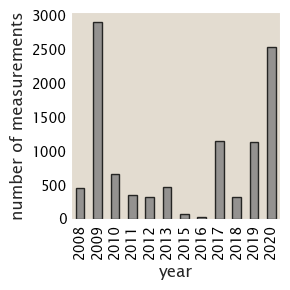

In [6]:
# parse the year from the Entry_date field
srdb['year'] = pd.to_datetime(srdb.Entry_date).dt.year
# plot the number of measurements per year
fig, axs = plt.subplots(figsize=(3,3))
srdb.groupby('year').size().plot(kind='bar', color='grey', edgecolor='k', lw=1, alpha=0.8)
plt.xlabel('year', fontsize=12)
plt.ylabel('number of measurements', fontsize=12)
plt.tight_layout()

In [7]:
# build a random forest regression model predicting Rs_annual from the 
# variables for which we have a fair bit of data

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# add a quantitative drainage variable that maps 
# dry, medium, mixed, wet to 1, 2, 3, 4
drainage_map = {'Dry': 1, 'Medium': 2, 'Mixed': 3, 'Wet': 4}
srdb['Soil_drainage_quant'] = srdb.Soil_drainage.map(drainage_map)

# drop rows with missing data
cols = ['Rs_annual', 'Soil_CN', 'MAT', 'MAP', ]
# Commented out columns are low on data or don't contribute much.
        # 'Soil_drainage_quant', 'Soil_sand', 'Soil_silt', 'Soil_clay', 'Soil_BD',
        # 'PET']

srdb_fitting = srdb.dropna(subset=cols)
print(f'{len(srdb_fitting)} rows have complete data.')
X = srdb_fitting[cols[1:]]
y = srdb_fitting['Rs_annual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSE/mean: {rmse/y_test.mean():.2f}')

907 rows have complete data.
R2: 0.35
RMSE: 491.06
RMSE/mean: 0.57


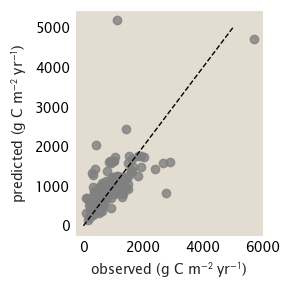

In [8]:
# plot the predicted vs. observed values
fig, axs = plt.subplots(figsize=(3,3))
plt.scatter(y_test, y_pred, color='grey', alpha=0.8)
plt.plot([0, 5000], [0, 5000], 'k--', lw=1)
plt.xlabel('observed (g C m$^{-2}$ yr$^{-1}$)', fontsize=10)
plt.ylabel('predicted (g C m$^{-2}$ yr$^{-1}$)', fontsize=10)
plt.tight_layout()

In [9]:
# Same regression as above, but drop the Soil_CN variable
X = srdb_fitting[cols[2:]]
y = srdb_fitting['Rs_annual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSE/mean: {rmse/y_test.mean():.2f}')


R2: 0.25
RMSE: 525.20
RMSE/mean: 0.61


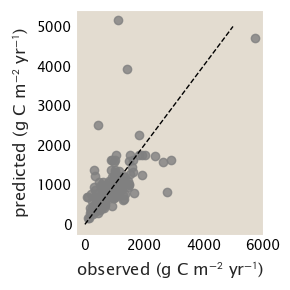

In [10]:
# plot the predicted vs. observed values
fig, axs = plt.subplots(figsize=(3,3))
plt.scatter(y_test, y_pred, color='grey', alpha=0.8)
plt.plot([0, 5000], [0, 5000], 'k--', lw=1)
plt.xlabel('observed (g C m$^{-2}$ yr$^{-1}$)', fontsize=12)
plt.ylabel('predicted (g C m$^{-2}$ yr$^{-1}$)', fontsize=12)
plt.tight_layout()

In [11]:
print(X.columns)
print(rf.feature_importances_)

Index(['MAT', 'MAP'], dtype='object')
[0.60969317 0.39030683]


In [12]:
# convert srdb into a geopandas dataframe
srdb['geometry'] = gpd.points_from_xy(srdb.Longitude, srdb.Latitude)
srdb['size'] = 1
srdb_geo = gpd.GeoDataFrame(srdb, geometry='geometry')

# add another layer for the points with missing data
mask = np.logical_or(srdb_geo.Rs_annual > 0, srdb_geo.Rh_annual > 0)
# additionally filter out points older than 2010
mask = np.logical_and(mask, srdb_geo.Entry_datetime.dt.year > 2010)

masked = srdb_geo[mask]
n_tot = masked.shape[0]
fig = go.Figure(data=go.Scattergeo(
        lon = masked['Longitude'],
        lat = masked['Latitude'],
        mode = 'markers',
        marker_size = 3,
        marker_color = 'darkgrey',
        ))

mask2 = np.logical_and(mask, srdb_geo.Soil_CN > 0)
masked = srdb_geo[mask2]
n_chem = masked.shape[0]
fig.add_trace(go.Scattergeo(
        lon = masked['Longitude'],
        lat = masked['Latitude'],
        mode = 'markers',
        marker_size = 3,
        marker_color = masked['Soil_CN'],
        ))

# disable the legend
fig.update_layout(showlegend=False)
fig.update_layout(
    geo = dict(
        showland = True,
        landcolor = "cornsilk",
        showcountries=False,
        countrycolor='black'
    )
)

print(f'Number of points with data: {n_tot}')
print(f'Number of points with data and chemistry: {n_chem}')
print(f'Percent of points with data and chemistry: {100*n_chem/n_tot:.1f}%')

# save the figure
fig.write_image('../output/srdb_map_since2010_chem.png', width=800, height=500, scale=2)

fig.show()

Number of points with data: 3401
Number of points with data and chemistry: 1009
Percent of points with data and chemistry: 29.7%


In [13]:
# use plotly to make a scatter plot on a map
mask = srdb_geo.Soil_CN.isnull()
fig = px.scatter_geo(srdb_geo[mask], lat='Latitude', lon='Longitude', color='size',
                     projection='natural earth', size='size', opacity=0.8)

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_11065/1698265871.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



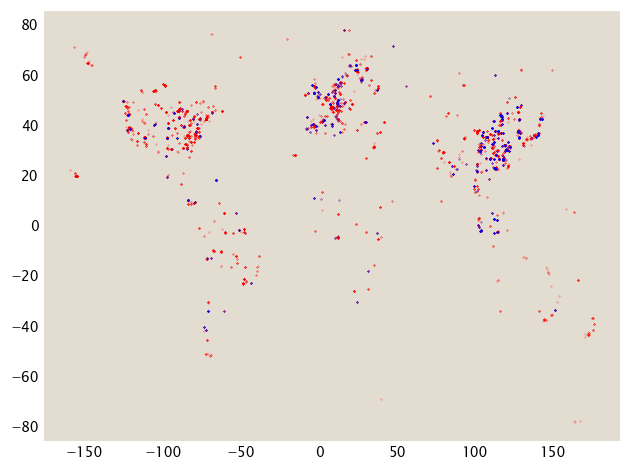

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=axs, color='white', edgecolor='k', lw=1, alpha=0.8)
mask = np.logical_or(srdb.Rh_annual.notnull(), srdb.Rs_annual.notnull())
mask2 = np.logical_and(mask, srdb.Soil_CN.notnull())
masked = srdb[mask]
masked2 = srdb[mask2]
plt.scatter(masked.Longitude, masked.Latitude, s=0.05, color='r', alpha=0.8)
plt.scatter(masked2.Longitude, masked2.Latitude, s=0.05, color='b', alpha=0.8)
plt.tight_layout()
plt.show()

In [15]:
fraction_w_CN = masked2.shape[0] / masked.shape[0]
print(f'Fraction of measurements with CN data: {fraction_w_CN:.2f}')

Fraction of measurements with CN data: 0.21
